IMDB - BERT MULTILINGUAL - 50000 Data

In [1]:
!nvidia-smi

Fri Apr  5 11:48:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.10              Driver Version: 535.86.10    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080        On  | 00000000:04:00.0 Off |                  N/A |
|  0%   27C    P8               7W / 180W |      1MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os

# Set the CUDA_VISIBLE_DEVICES environment variable to the index of the GPU you want to use
os.environ["CUDA_VISIBLE_DEVICES"] = "4" 

In [3]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained("bert-base-multilingual-cased")

/home/hygumm/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
import torch
from transformers import BertModel
import torch.nn as nn
from torch.optim import Adam
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [5]:
import torch
torch.cuda.empty_cache()

In [6]:
df = pd.read_csv("imdb.csv")
df

,Unnamed: 0,text,label
0,0,Forget what I said about Emeril. Rachael Ray i...,0
1,1,Former private eye-turned-security guard ditch...,0
2,2,Mann photographs the Alberta Rocky Mountains i...,0
3,3,Simply put: the movie is boring. Cliché upon c...,0
4,4,"Now being a fan of sci fi, the trailer for thi...",1
...,...,...,...
49995,49995,"The ""documentary"", and we use that term loosel...",0
49996,49996,This outlandish Troma movie is actually a very...,1
49997,49997,I found the film Don't Look In The Basement to...,1
49998,49998,I have read the novel Reaper of Ben Mezrich a ...,0


In [7]:
# Assuming the dataset is loaded from a CSV file
df.drop('Unnamed: 0', inplace= True, axis=1)
# df = df.sample(n=1000, replace=False)

# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

class IMDbDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=256):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = dataframe.label
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'ids': inputs['input_ids'].flatten(),
            'mask': inputs['attention_mask'].flatten(),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)
        }

# Create training and validation datasets
train_dataset = IMDbDataset(train_df, tokenizer)
test_dataset = IMDbDataset(test_df, tokenizer)

# DataLoader parameters
train_params = {'batch_size': 8, 'shuffle': True, 'num_workers': 0}
test_params = {'batch_size': 8, 'shuffle': False, 'num_workers': 0}

# Loaders
training_loader = DataLoader(train_dataset, **train_params)
testing_loader = DataLoader(test_dataset, **test_params)


In [8]:


class BERTLSTM(nn.Module):
    def __init__(self):
        super(BERTLSTM, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-multilingual-cased")
        self.lstm = nn.LSTM(768, 256, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(256*2, 1)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            _, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)

        lstm_output, (hidden_state, _) = self.lstm(pooled_output.unsqueeze(1))
        hidden_state = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim=1)
        linear_output = self.linear(hidden_state)
        return torch.sigmoid(linear_output)

In [ ]:
# Quick test to see if DataLoader works correctly
for i, data in enumerate(training_loader):
    print(f"Batch {i}: {data['ids'].size()}")
    if i == 10:  # Just check the first 10 batches
        break


In [9]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BERTLSTM().to(device)
optimizer = Adam(model.parameters(), lr=1e-5)

def train(epoch):
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask).squeeze()
        optimizer.zero_grad()
        loss = nn.BCELoss()(outputs, targets)
        if _%5000==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        loss.backward()
        optimizer.step()

for epoch in range(3):  # Example for 3 epochs
    train(epoch)


Epoch: 0, Loss:  0.6913712024688721
Epoch: 1, Loss:  0.6981779932975769
Epoch: 2, Loss:  0.6384446620941162


In [10]:
 def evaluate():
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask).squeeze()
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.round(outputs).cpu().detach().numpy().tolist())
    return accuracy_score(fin_targets, fin_outputs)

print(f'Test Accuracy: {evaluate()}')

Test Accuracy: 0.6613


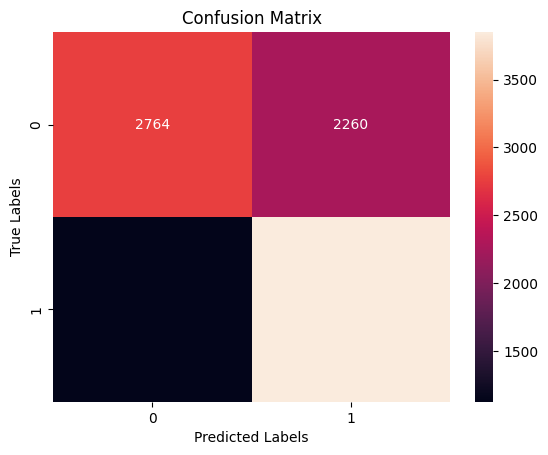

In [11]:

def get_predictions(loader):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for data in loader:
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float)
            outputs = model(ids, mask).squeeze()
            predictions.extend(torch.round(outputs).cpu().detach().numpy().tolist())
            true_labels.extend(targets.cpu().detach().numpy().tolist())
    return predictions, true_labels

# Get predictions and true labels
predictions, true_labels = get_predictions(testing_loader)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predictions)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [12]:
# Calculate TP, FP, TN, FN
TP = cm[1][1]
FP = cm[0][1]
TN = cm[0][0]
FN = cm[1][0]

print("True Positives (TP):", TP)
print("False Positives (FP):", FP)
print("True Negatives (TN):", TN)
print("False Negatives (FN):", FN)

True Positives (TP): 3849
False Positives (FP): 2260
True Negatives (TN): 2764
False Negatives (FN): 1127


In [30]:
def predict_sentiment(text):
    model.eval()
    inputs = tokenizer.encode_plus(
        text,
        None,
        add_special_tokens=True,
        max_length=256,
        padding='max_length',
        return_token_type_ids=True,
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    ids = inputs['input_ids'].to(device, dtype=torch.long)
    mask = inputs['attention_mask'].to(device, dtype=torch.long)
    
    with torch.no_grad():
        output = model(ids, mask).squeeze()
    
    prediction = torch.round(output).cpu().numpy()
    return "Positive" if prediction == 1 else "Negative"

# Example usage
example_text = "I loved the movie, it was fantastic i really loved it!"
print(predict_sentiment(example_text))

Positive


In [14]:
# Example usage
example_text = '''"Aaaaand The Star Buoy hits it out of the park yet again!

What a hilarious ride. Tillu is a true blue phenomenon in the realm of Telugu Cinema 💙 
And nobody can do justice to it like Siddu!
What energy, what charm ❤️

Tillu is not to be reviewed, questioned, or analyzed. He is simply meant to be loved, 
so gooo watch and enjoy the fun partyyy! The one-liners and Anupama(superbly written - stellar performance)
are the other standouts in this Siddu Jonnalagadda  bonanza 🎉 Don'tttt missss!"'''
print(predict_sentiment(example_text))

Positive
